## 4. Pytorch Custom Datasets
Previously we used in-built dataset in Pytorch(FashionMNIST) Here we will be using a custom dataset to build a model

### What we're going to cover
We will be applying the same workflow we used in the previous notebooks.But instead we will be using our own dataset of pizza,steak and sushi images.


### 0. Importing Pytorch and seeting up device agnostics

In [2]:
import torch
from torch import nn

In [3]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

### 1. Get data
The data we are going to use is from dataset called "Food 101 dataset". This contains 1000 images of 101 different kinds of food, totalling 101,100 images .But ,instead of 101 food classes , we're going to start with 3:pizza,steak and sushi. and intead of 1000 images per classes we're going to start with random 10% and increase from there

In [4]:
import requests
import zipfile
from pathlib import Path

# Setup path to data folder
data_path = Path("data/")
image_path = data_path / "pizza_steak_sushi"

# If the image folder doesn't exist, download it and prepare it... 
if image_path.is_dir():
    print(f"{image_path} directory exists.")
else:
    print(f"Did not find {image_path} directory, creating one...")
    image_path.mkdir(parents=True, exist_ok=True)
    
    # Download pizza, steak, sushi data
    with open(data_path / "pizza_steak_sushi.zip", "wb") as f:
        request = requests.get("https://github.com/mrdbourke/pytorch-deep-learning/raw/main/data/pizza_steak_sushi.zip")
        print("Downloading pizza, steak, sushi data...")
        f.write(request.content)

    # Unzip pizza, steak, sushi data
    with zipfile.ZipFile(data_path / "pizza_steak_sushi.zip", "r") as zip_ref:
        print("Unzipping pizza, steak, sushi data...") 
        zip_ref.extractall(image_path)

data\pizza_steak_sushi directory exists.


### 2. Become one with the data(data preparation)
Before starting a project or building any kind of model, it's important to know what data you're working with.<br>
In our case, we have images of pizza,steak and sushi in standard image classification format.<br>
Image classification format contains separate classes of images in seperate directories titled with a particular class name



The goal will be to **take this data storage structure and turn it into a dataset usable with Pytorch.**

We can inspect what's in our data directory by writing a small helper function to walk through each of the subdirectories and count the files present.<br>
To do so, we'll use Python's in-built os.walk()

In [5]:
import os
def walk_through_dir(dir_path):
    """
    Walks through dir_path returning it's contents.
    Args:
      dir_paths(str or pathlib.Path) : target directory
    Returns:
      A print out of:
      number of subdirectories in dir_path
      number of images(files) in each subdirectory
      name of each subdirectory
    """
    for dirpath,dirnames,filenames in os.walk(dir_path):
        print(f"There are {len(dirnames)} directories and {len(filenames)} images in '{dirpath}'")

In [6]:
walk_through_dir(image_path)

There are 2 directories and 0 images in 'data\pizza_steak_sushi'
There are 3 directories and 0 images in 'data\pizza_steak_sushi\test'
There are 0 directories and 25 images in 'data\pizza_steak_sushi\test\pizza'
There are 0 directories and 19 images in 'data\pizza_steak_sushi\test\steak'
There are 0 directories and 31 images in 'data\pizza_steak_sushi\test\sushi'
There are 3 directories and 0 images in 'data\pizza_steak_sushi\train'
There are 0 directories and 78 images in 'data\pizza_steak_sushi\train\pizza'
There are 0 directories and 75 images in 'data\pizza_steak_sushi\train\steak'
There are 0 directories and 72 images in 'data\pizza_steak_sushi\train\sushi'


Looks like we have 75 images per training class and 25 images per testing class

In [7]:
# let's setup our training and testing paths.
train_dir = image_path / "train"
test_dir = image_path  / "test"
train_dir,test_dir


(WindowsPath('data/pizza_steak_sushi/train'),
 WindowsPath('data/pizza_steak_sushi/test'))

### 2.1 Visualize an image


Random image path: data\pizza_steak_sushi\test\sushi\2394442.jpg
Image class: sushi
Image height: 408
Image width: 512


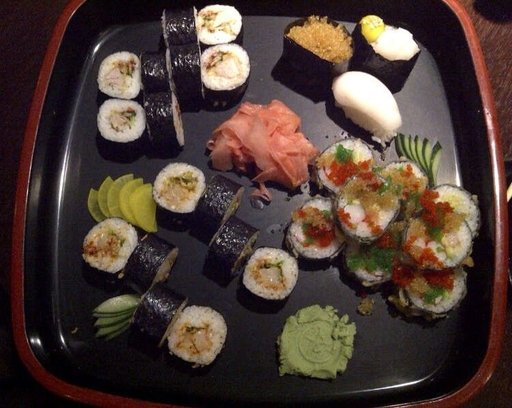

In [8]:
import random
from PIL import Image

random.seed(42)
# 1. Get all image paths (* means "any combination")
image_path_list = list(image_path.glob("*/*/*.jpg"))

# 2. Get random image path
random_image_path = random.choice(image_path_list)

#3. Get images class from path name(the image class is name of the directory where the image is stored)
image_class = random_image_path.parent.stem

#4. Open image
img = Image.open(random_image_path)

#5. Print metadata
print(f"Random image path: {random_image_path}")
print(f"Image class: {image_class}")
print(f"Image height: {img.height}") 
print(f"Image width: {img.width}")
img


We can do the same with matplotlib.pyplot.imshow(), except we have to convert the images into a NumPy array first.

Text(0.5, 1.0, 'Image class : sushi | Image shape: (408, 512, 3) -> [height,width,color_channels]')

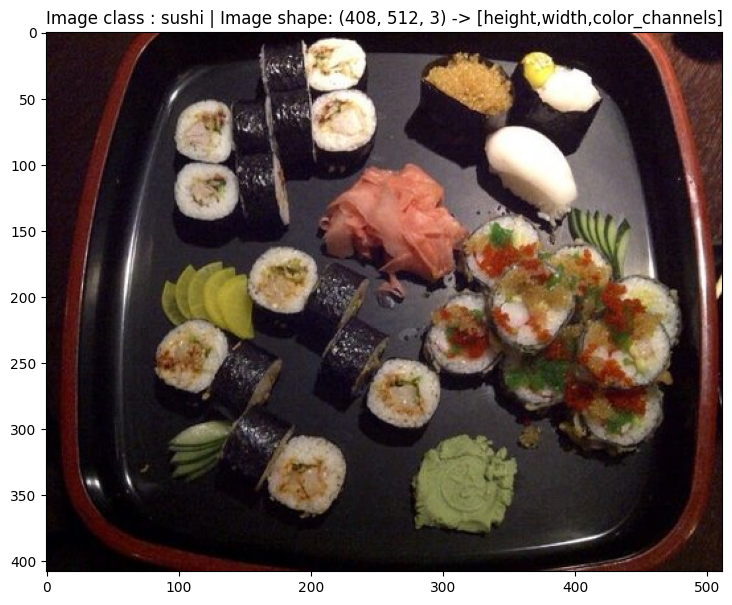

In [9]:
import numpy as np
import matplotlib.pyplot as plt

images_as_array = np.asarray(img)

plt.figure(figsize=(10,7))
plt.imshow(images_as_array)
plt.title(f"Image class : {image_class} | Image shape: {images_as_array.shape} -> [height,width,color_channels]")

### 3. Transforming data
Ww want to load our image data into Pytorch, so we will take the following steps.

1. Turn it into tensors(numerical representations of our images).
2. Turn it into a torch.utils.data.Dataset and subsequently a torch.utils.data.DataLoader, we'll call these Dataset and DataLoader for short

In [10]:
from torch.utils.data import DataLoader
from torchvision import datasets, transforms

#### 3.1 Transforming data with torchvision.transforms
We have got folders of images but before we use them , we have to convert them into tensors.One of the ways we can do this is by using the torchvision.transforms module.
<br>
<br>
torchvision.transforms contains many pre-built methods for formatting images,turining them into tensors and even manipulating them for data augmentation.
<br>
to get experience with torchvision.transform, let's write a series of transform steps that:
- Resize the images using transforms.Resize() (from about 512x512 to 64x64, the same shape as the images on the CNN Explainer website).
- Flip our images randomly on the horizontal using transforms.RandomHorizontalFlip() (this could be considered a form of data augmentation because it will artificially change our image data).
- Turn our images from a PIL image to a PyTorch tensor using transforms.ToTensor().

In [11]:
data_transform = transforms.Compose([transforms.Resize(size=(64,64)),
                                     transforms.RandomHorizontalFlip(p=0.5),
                                     transforms.ToTensor()])

Let's make a function to try them out on various images.


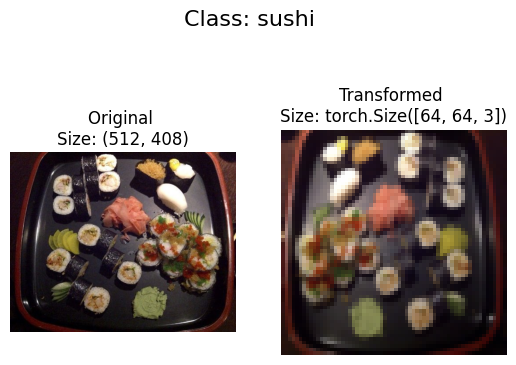

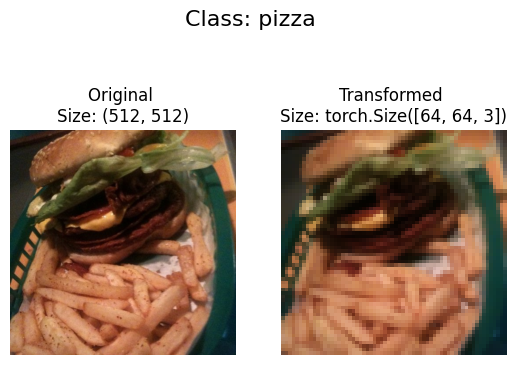

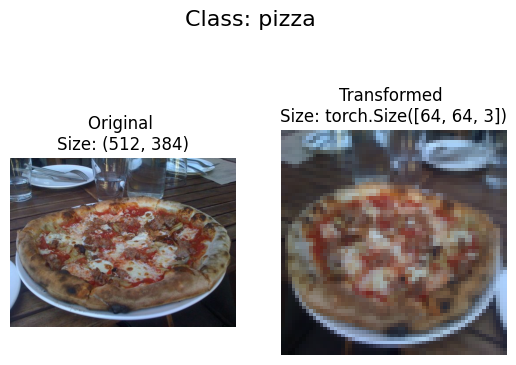

In [12]:
def plot_transformed_images(image_paths, transform, n=3, seed=42):
    """Plots a series of random images from image_paths.

    Will open n image paths from image_paths, transform them
    with transform and plot them side by side.

    Args:
        image_paths (list): List of target image paths. 
        transform (PyTorch Transforms): Transforms to apply to images.
        n (int, optional): Number of images to plot. Defaults to 3.
        seed (int, optional): Random seed for the random generator. Defaults to 42.
    """
    random.seed(seed)
    random_image_paths = random.sample(image_paths, k=n)
    for image_path in random_image_paths:
        with Image.open(image_path) as f:
            fig, ax = plt.subplots(1, 2)
            ax[0].imshow(f) 
            ax[0].set_title(f"Original \nSize: {f.size}")
            ax[0].axis("off")

            # Transform and plot image
            # Note: permute() will change shape of image to suit matplotlib 
            # (PyTorch default is [C, H, W] but Matplotlib is [H, W, C])
            transformed_image = transform(f).permute(1, 2, 0) 
            ax[1].imshow(transformed_image) 
            ax[1].set_title(f"Transformed \nSize: {transformed_image.shape}")
            ax[1].axis("off")

            fig.suptitle(f"Class: {image_path.parent.stem}", fontsize=16)

plot_transformed_images(image_path_list, 
                        transform=data_transform, 
                        n=3)

### 4. Option 1 : Loading Image Data using ImageFolder
Now, we have to convert our data into a dataset capabale of being used with pytorch.
<br>
Since our data is in standard image classification format, we can use the class torchvision.datasets.ImageFolder<br>
we can pass it the file path of a target image directory as well as a series of transforms we'd like to perform on our images.<br>


In [13]:
from torchvision import datasets
train_data = datasets.ImageFolder(root = train_dir,
                                  transform = data_transform,
                                  target_transform=None)#not necessary on labels
test_data = datasets.ImageFolder(root=test_dir,
                                 transform = data_transform)
print(f"Train data:\n{train_data}\nTest data:\n{test_data}")

Train data:
Dataset ImageFolder
    Number of datapoints: 225
    Root location: data\pizza_steak_sushi\train
    StandardTransform
Transform: Compose(
               Resize(size=(64, 64), interpolation=bilinear, max_size=None, antialias=True)
               RandomHorizontalFlip(p=0.5)
               ToTensor()
           )
Test data:
Dataset ImageFolder
    Number of datapoints: 75
    Root location: data\pizza_steak_sushi\test
    StandardTransform
Transform: Compose(
               Resize(size=(64, 64), interpolation=bilinear, max_size=None, antialias=True)
               RandomHorizontalFlip(p=0.5)
               ToTensor()
           )


In [21]:
# get classes name as a list
class_names = train_data.classes
class_names

['pizza', 'steak', 'sushi']

In [22]:
len(train_data),len(test_data)

(225, 75)

In [38]:
img,label = train_data[0][0],train_data[0][1]
print(f"Image tensor : \n {img}")
print(f"Image shape: {img.shape}")
print(f"Image datatype: {img.dtype}")
print(f"Image label : {label}")
print(f"Label datatype : {type(label)}")


Image tensor : 
 tensor([[[0.1137, 0.1020, 0.0980,  ..., 0.1255, 0.1216, 0.1176],
         [0.1059, 0.0980, 0.0980,  ..., 0.1294, 0.1294, 0.1294],
         [0.1020, 0.0980, 0.0941,  ..., 0.1333, 0.1333, 0.1333],
         ...,
         [0.1098, 0.1098, 0.1255,  ..., 0.1686, 0.1647, 0.1686],
         [0.0902, 0.0941, 0.1098,  ..., 0.1686, 0.1647, 0.1686],
         [0.0863, 0.0863, 0.0980,  ..., 0.1686, 0.1647, 0.1647]],

        [[0.0745, 0.0706, 0.0745,  ..., 0.0588, 0.0588, 0.0588],
         [0.0745, 0.0706, 0.0745,  ..., 0.0627, 0.0627, 0.0627],
         [0.0706, 0.0745, 0.0745,  ..., 0.0706, 0.0706, 0.0706],
         ...,
         [0.1255, 0.1333, 0.1373,  ..., 0.2510, 0.2392, 0.2392],
         [0.1098, 0.1176, 0.1255,  ..., 0.2510, 0.2392, 0.2314],
         [0.1020, 0.1059, 0.1137,  ..., 0.2431, 0.2353, 0.2275]],

        [[0.0941, 0.0902, 0.0902,  ..., 0.0157, 0.0196, 0.0196],
         [0.0902, 0.0863, 0.0902,  ..., 0.0196, 0.0157, 0.0196],
         [0.0902, 0.0902, 0.0902,  ..., 0

Our images are now in the form of tensor with shape (3,64,64) and labels are in the form of an integer relating to a specific class
<br>
How about we plot a single image tensor using matplotlib?<br>
Right now our image dimensions are in the form (CHW) lets permute(rearrange the order of it's dimensions)so it's more compatible with matplotlib

In [39]:
image_permute = img.permute(1,2,0)

#print out different shapes(before and after permute)
print(f"Original Shape : {img.shape}")
print(f"Image permute Shape : {image_permute.shape}")

Original Shape : torch.Size([3, 64, 64])
Image permute Shape : torch.Size([64, 64, 3])


Text(0.5, 1.0, 'pizza')

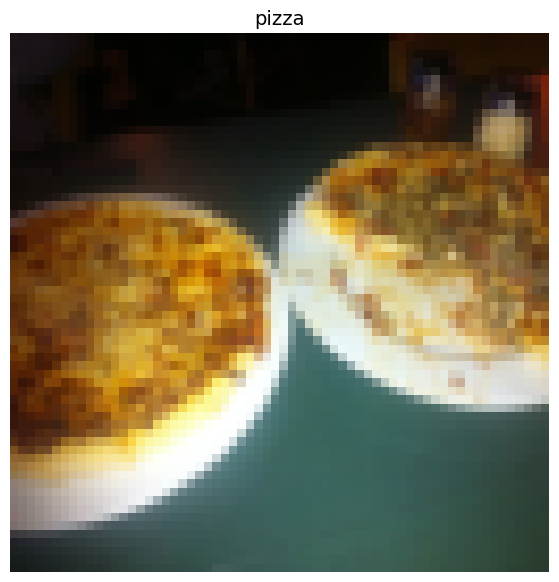

In [40]:
#plot the image
plt.figure(figsize=(10,7))
plt.imshow(img.permute(1,2,0))
plt.axis("off")
plt.title(class_names[label],fontsize=14)

### 4.1 Turn loaded images into DataLoader's
We've got our images as Pytorch Dataset's but now let's turn them into DataLoader's<br>
<br>
Turning our Dataset's into DataLoader's makes them iterable so a model can go through and learn the relationships between samples and targets.
<br>
To keep things simple, we'll use a batch_size =1 and num_workers = 1
<br>
What is num_workers?
<br>
It defines how many subprocesses will be created to load your data.The more high this value the more compute power Pytorch will use to load your data


In [44]:
# turn train and test Datasets into DataLoaders
from torch.utils.data import DataLoader
train_dataloader = DataLoader(train_data,batch_size=1,num_workers=1,shuffle=True)
test_dataloader = DataLoader(test_data,batch_size=1,num_workers=1,shuffle=False)
train_dataloader,test_dataloader

(<torch.utils.data.dataloader.DataLoader at 0x1f4e27c5400>,
 <torch.utils.data.dataloader.DataLoader at 0x1f4e2744e30>)

Now our data is iterable

In [47]:
img,label = next(iter(train_dataloader))
print(f"Image shape: {img.shape}")
print(f"Label shape: {label.shape}")


Image shape: torch.Size([1, 3, 64, 64])
Label shape: torch.Size([1])


### 5 Create a function to display random images


In [56]:
# 1. Take in a Dataset as well as a list of class names
def display_random_images(dataset: torch.utils.data.dataset.Dataset,
                          classes: list[str] = None,
                          n: int = 10,
                          display_shape: bool = True,
                          seed: int = None):
    
    # 2. Adjust display if n too high
    if n > 10:
        n = 10
        display_shape = False
        print(f"For display purposes, n shouldn't be larger than 10, setting to 10 and removing shape display.")
    
    # 3. Set random seed
    if seed:
        random.seed(seed)

    # 4. Get random sample indexes
    random_samples_idx = random.sample(range(len(dataset)), k=n)

    # 5. Setup plot
    plt.figure(figsize=(16, 8))

    # 6. Loop through samples and display random samples 
    for i, targ_sample in enumerate(random_samples_idx):
        targ_image, targ_label = dataset[targ_sample][0], dataset[targ_sample][1]

        # 7. Adjust image tensor shape for plotting: [color_channels, height, width] -> [color_channels, height, width]
        targ_image_adjust = targ_image.permute(1, 2, 0)

        # Plot adjusted samples
        plt.subplot(1, n, i+1)
        plt.imshow(targ_image_adjust)
        plt.axis("off")
        if classes:
            title = f"class: {classes[targ_label]}"
            if display_shape:
                title = title + f"\nshape: {targ_image_adjust.shape}"
        plt.title(title)

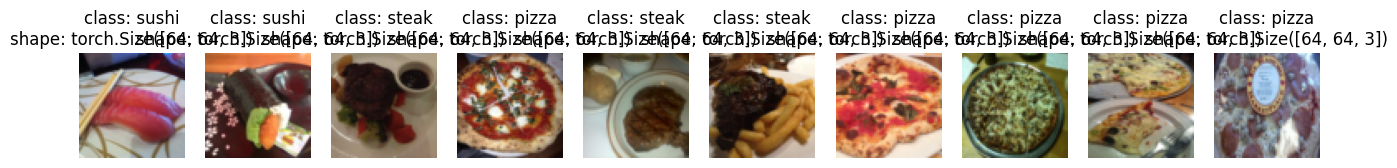

In [59]:
# Display random images from ImageFolder created Dataset
display_random_images(train_data, 
                      n=10, 
                      classes=class_names,
                      seed=None)

### Model 0 : TinyVGG without data augmentation
Now let's construct a computer vision model to see if we can classify images of pizza ,steak and sushi
<br>
to begin we'll start with a simple transform, only resizing the images to (64,64) and turning them into tensors.


In [62]:
# create a transformation
simple_transform = transforms.Compose([transforms.Resize((64,64)),
                                      transforms.ToTensor()])


In [65]:
#1 Load and transform data
from torchvision import datasets
train_data_simple = datasets.ImageFolder(root=train_dir,transform = simple_transform)
test_data_simple = datasets.ImageFolder(root=test_dir,transform = simple_transform)

#2 Turn data into data loaders
import os
NUM_WORKER = os.cpu_count()
BATCH_SIZE = 32
print(f"Creating a dataloader with batch size {BATCH_SIZE} and no of worker {NUM_WORKER}")

# Create dataloader
train_dataloader_simple = DataLoader(train_data_simple,
                                      batch_size=BATCH_SIZE,
                                      num_workers=NUM_WORKER)
test_dataloader_simple = DataLoader(test_data_simple,
                                    batch_size=BATCH_SIZE,
                                    num_workers=NUM_WORKER)
train_dataloader_simple,test_dataloader_simple

Creating a dataloader with batch size 32 and no of worker 16


(<torch.utils.data.dataloader.DataLoader at 0x1f4e41c1cd0>,
 <torch.utils.data.dataloader.DataLoader at 0x1f4e41c23f0>)